<a href="https://colab.research.google.com/github/ML-HW-SYS/a2-ethanglaser/blob/main/1_audio_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Preprocessing: Audio Recording and Visualization**

*You do not need to write any code for this section; simply run and explore the impact of the code below.*

## 1.0 Setup GDrive and Git

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username    
with open('/content/gdrive/MyDrive/ece5545/user.txt') as f:
    handle = f.readline().strip()

In [7]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a2-ethanglaser' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a2-ethanglaser
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
/content/gdrive/MyDrive/ece5545


In [8]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

## 1.1 Setup Recording Capabilities
\*Start clearing your throat: *ahem-ahem*\*

### Install required packages

In [9]:
!pip install ffmpeg-python &> 0
!pip install torchaudio
!pip install pydub 
print("Packages Installed")

Packages Installed



### Import code dependencies

In [10]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
import ffmpeg
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
import librosa
import torch
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
import torchaudio.transforms as T
import torch.fft
import pydub
print("Packages Imported")

Packages Imported


### Define the audio recording function
This function allows you to manually record audio samples to use as your dataset. The decoding part refers to decoding the bytes-like object and returning the decoded bytes. The bytes are then converted into .wav files which are used for the audio samples.

Adapted from: https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio_tutorial.html#formatting-the-data

In [11]:
def record(seconds=1):
    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)

## 1.2 Load in the Audio Samples
### Record your own audio samples!
You will have 1 second to record "yes"/"no" at "loud"/"quiet" volumes in the respective cells. The recording starts immediately, but you can re-record as many times as you would like.

**If you do not want to record audio, then see below for a way to load in the default audio used in the lecture slides.**

In [13]:
audio_yes_loud, sr_yes_loud = record()
print("DONE")

Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
DONE


In [15]:
audio_yes_quiet, sr_yes_quiet = record()
print("DONE")

Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
DONE


In [16]:
audio_no_loud, sr_no_loud = record()
print("DONE")

Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
DONE


In [17]:
audio_no_quiet, sr_no_quiet = record()
print("DONE")

Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
DONE


You can hear your recorded audio files by running the below code. Make sure the recording doesn't cut off your "yes"/"no" statements.

In [18]:
Audio(audio_yes_loud, rate=sr_yes_loud)

In [19]:
Audio(audio_yes_quiet, rate=sr_yes_quiet)

In [20]:
Audio(audio_no_loud, rate=sr_no_loud)

In [21]:
Audio(audio_no_quiet, rate=sr_no_quiet)

## 1.3 Visualize the Audio Samples

### Time domain
This part of the notebook represents the .wav audio samples as signals plotted on a graph. The x-axis of the graphs represent time and is derived using frame rate. The graphs depict the magnitudes of sound of the audio samples.

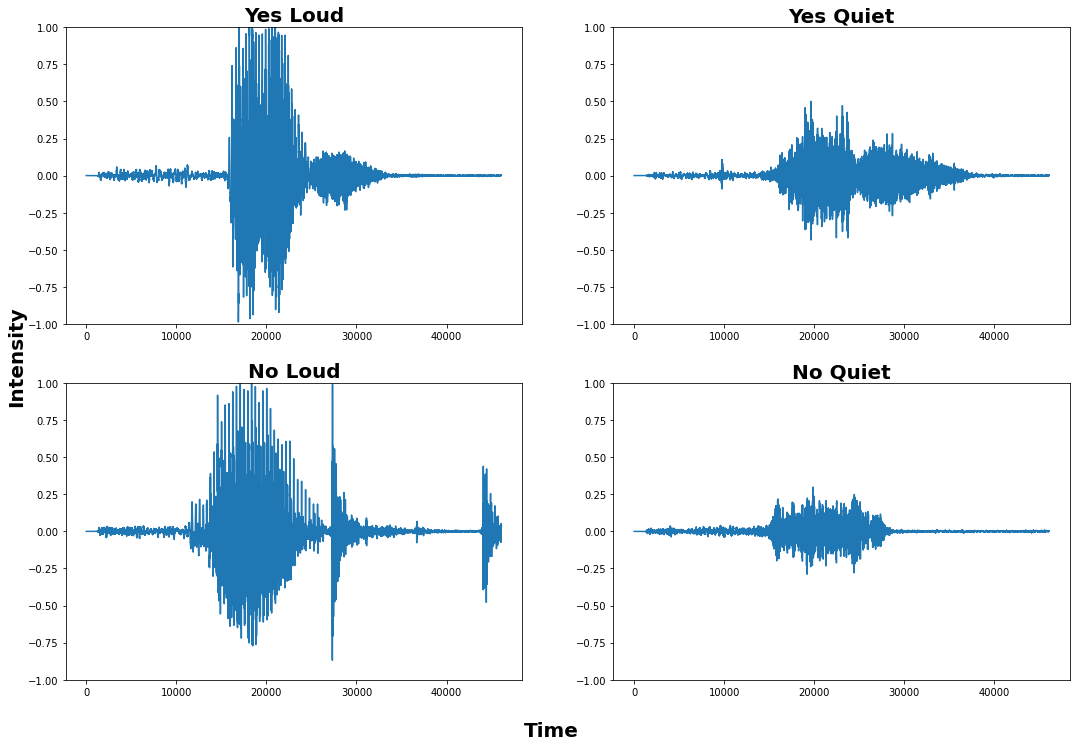

In [22]:
# Plot the figures
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
tensor_cat = torch.cat((torch.cat((torch.cat((audio_yes_loud,audio_yes_quiet), 1),audio_no_loud),1),audio_no_quiet), 1)
max_val = tensor_cat.max().item()

ax1.plot(audio_yes_loud.t().numpy())
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(-max_val, max_val)

ax2.plot(audio_yes_quiet.t().numpy())
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(-max_val, max_val)

ax3.plot(audio_no_loud.t().numpy())
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(-max_val, max_val)

ax4.plot(audio_no_quiet.t().numpy())
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(-max_val, max_val)

fig.set_size_inches(18,12)
fig.text(0.5, 0.06, 'Time', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Intensity', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');

### Frequency domain
Here, the audio samples are displayed in the frequency domain through Fourier transformations. The x axis, instead of representing time, now represents frequency, and the y axis represents the amount of decibels in the sample at each frequency.

Adapted from: https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform

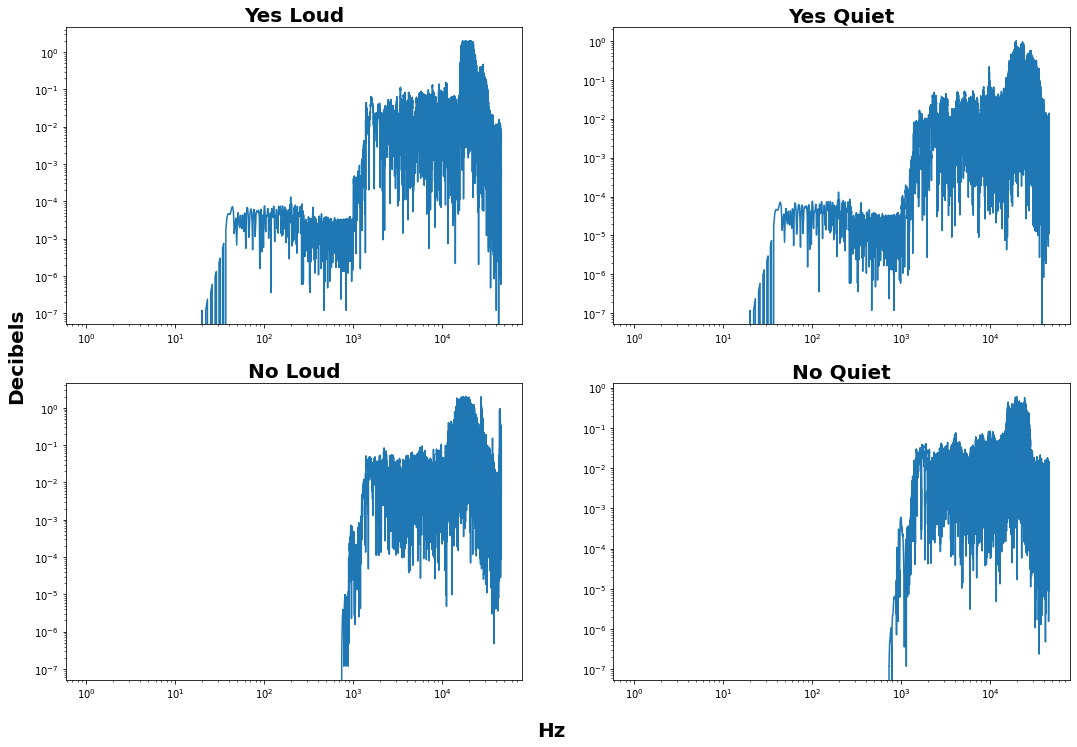

In [23]:
# Compute the FFT and take the single-sided spectrum only and remove imaginary part
ft_audio_yes_loud = torch.abs(2*torch.fft.fft(audio_yes_loud.t()))
ft_audio_yes_quiet = torch.abs(2*torch.fft.fft(audio_yes_quiet.t()))
ft_audio_no_loud = torch.abs(2*torch.fft.fft(audio_no_loud.t()))
ft_audio_no_quiet = torch.abs(2*torch.fft.fft(audio_no_quiet.t()))

# Plot the figures
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

ax1.plot(ft_audio_yes_loud)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})

ax2.plot(ft_audio_yes_quiet)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})

ax3.plot(ft_audio_no_loud)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})

ax4.plot(ft_audio_no_quiet)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})

fig.set_size_inches(18,12)
fig.text(0.5, 0.06, 'Hz', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Decibels', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');

### Spectrograms
A spectogram is a figure which visually represents the spectrum of frequencies of a recorded audio over time. This part of the notebook produces those "pictures" of your audio samples. Brighter color indicates more concentration around specific frequencies. They are important in machine learning since they capture the shape and structure of audio in a format algorithms can manipulate.

For more information on spectrograms use in ML, checkout: [Learning from Audio: Spectrograms](https://towardsdatascience.com/learning-from-audio-spectrograms-37df29dba98c)

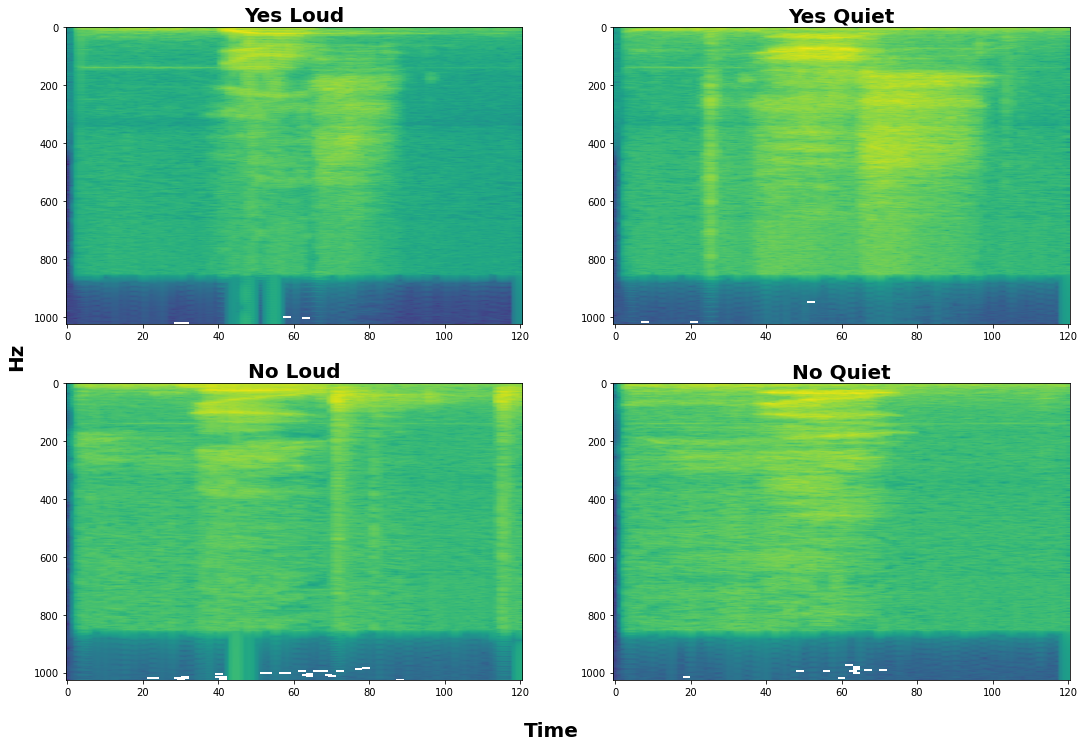

In [24]:
# Convert to spectrogram and display
def get_spectrogram(
    waveform,
    n_fft = 2048,
    win_len = None,
    hop_len = 16000 * 0.008,
    power = 2.0,
    ):
  
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
    )
    return spectrogram(waveform)

spectrogram_yes_loud = get_spectrogram(audio_yes_loud[0], hop_len = int(sr_yes_loud * 0.008))
spectrogram_yes_quiet = get_spectrogram(audio_yes_quiet[0], hop_len = int(sr_yes_quiet * 0.008))
spectrogram_no_loud = get_spectrogram(audio_no_loud[0], hop_len = int(sr_no_loud * 0.008))
spectrogram_no_quiet = get_spectrogram(audio_no_quiet[0], hop_len = int(sr_no_quiet * 0.008))

# Plot the figures
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

ax1.imshow(torch.log(spectrogram_yes_loud).numpy(), aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})

ax2.imshow(torch.log(spectrogram_yes_quiet).numpy(), aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})

ax3.imshow(torch.log(spectrogram_no_loud).numpy(), aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})

ax4.imshow(torch.log(spectrogram_no_quiet).numpy(), aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})

fig.set_size_inches(18,12)
fig.text(0.5, 0.06, 'Time', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Hz', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');

Can you see how spectrograms can help machine learning models better differentiate between audio samples?

### Mel spectrogram
Mel spectrograms are different from spectrograms in that they display frequencies on the mel scale, which is nonlinear. The purpose of this logarithmic transformation is to account for the fact that humans do not perceive frequencies on a linear scale. Therefore, using the mel scale can help us-- and ML algorithms-- better associate the features to human hearing.

Adapted from: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0

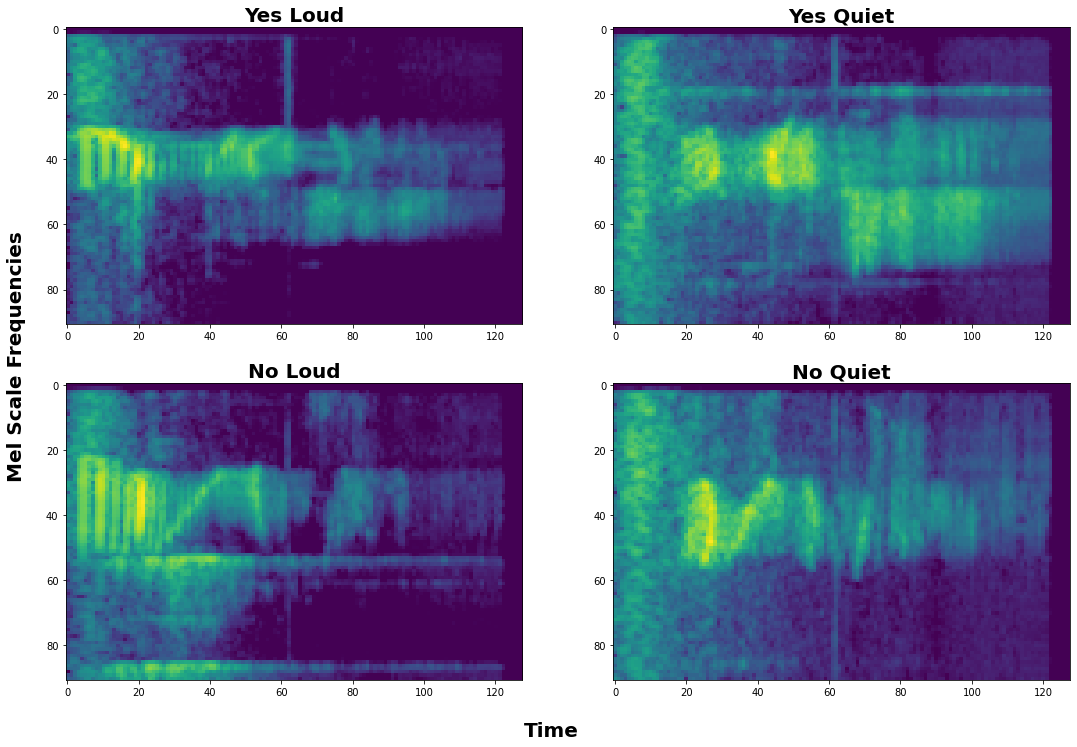

In [25]:
# Torchaudio mel spectrogram
def get_melspectrogram(
    waveform, 
    sample_rate,
    n_fft = 2048,
    win_length = None,
    hop_length = 512,
    n_mels = 128,
    ):

    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm='slaney',
        onesided=True,
        n_mels=n_mels,
    )
    return mel_spectrogram(waveform)

mel_yes_loud = get_melspectrogram(waveform=audio_yes_loud[0], sample_rate=sr_yes_loud)
mel_yes_quiet = get_melspectrogram(waveform=audio_yes_quiet[0], sample_rate=sr_yes_quiet)
mel_no_loud = get_melspectrogram(waveform=audio_no_loud[0], sample_rate=sr_no_loud)
mel_no_quiet = get_melspectrogram(waveform=audio_no_quiet[0], sample_rate=sr_no_quiet)

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

ax1.imshow(librosa.power_to_db(torch.swapaxes(mel_yes_loud, 0 ,1).numpy()), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(ax1.get_ylim()[::-1])

ax2.imshow(librosa.power_to_db(torch.swapaxes(mel_yes_quiet, 0 ,1).numpy()), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(ax2.get_ylim()[::-1])

ax3.imshow(librosa.power_to_db(torch.swapaxes(mel_no_loud, 0 ,1).numpy()), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(ax3.get_ylim()[::-1])

ax4.imshow(librosa.power_to_db(torch.swapaxes(mel_no_quiet, 0 ,1).numpy()), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(ax4.get_ylim()[::-1])

fig.set_size_inches(18,12)
fig.text(0.5, 0.06, 'Time', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Mel Scale Frequencies', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');

### Mel frequency cepstral coefficients (MFCC) spectrogram

Similar to spectrograms, MFCC is another way to visualize sound. It bands together frequencies according to the mel scale. 

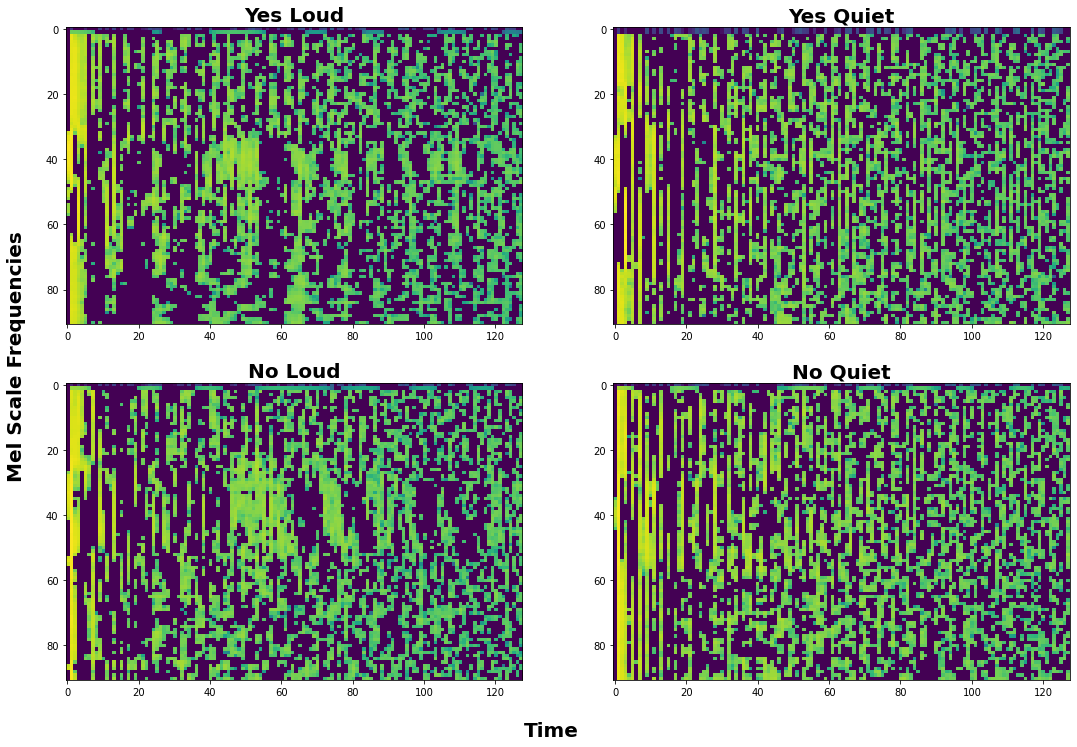

In [26]:
# Torchaudio MFCC
def get_mfcc(
    waveform,
    sample_rate,
    n_fft = 2048,
    win_length = None,
    hop_length = 512,
    n_mels = 128,
    n_mfcc = 128
    ):

    mfcc_transform = T.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,
        melkwargs={
            'n_fft': n_fft,
            'n_mels': n_mels,
            'hop_length': hop_length,
        }
    )

    mfcc = mfcc_transform(waveform)
    return mfcc

mfcc_yes_loud = get_mfcc(waveform=audio_yes_loud[0], sample_rate=sr_yes_loud)
mfcc_yes_quiet = get_mfcc(waveform=audio_yes_quiet[0], sample_rate=sr_yes_quiet)
mfcc_no_loud = get_mfcc(waveform=audio_no_loud[0], sample_rate=sr_no_loud)
mfcc_no_quiet = get_mfcc(waveform=audio_no_quiet[0], sample_rate=sr_no_quiet)

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

ax1.imshow(librosa.power_to_db(torch.swapaxes(mfcc_yes_loud, 0 ,1).numpy()), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(ax1.get_ylim()[::-1])

ax2.imshow(librosa.power_to_db(torch.swapaxes(mfcc_yes_quiet, 0 ,1).numpy()), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(ax2.get_ylim()[::-1])

ax3.imshow(librosa.power_to_db(torch.swapaxes(mfcc_no_loud, 0 ,1).numpy()), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(ax3.get_ylim()[::-1])

ax4.imshow(librosa.power_to_db(torch.swapaxes(mfcc_no_quiet, 0 ,1).numpy()), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(ax4.get_ylim()[::-1])

fig.set_size_inches(18,12)
fig.text(0.5, 0.06, 'Time', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Mel Scale Frequencies', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');

If you would like to learn more about Mel Spectrograms and MFCC, check out these links (as a starting point): 
* [Learning from Audio: The Mel Scale, Mel Spectrograms, and Mel Frequency Cepstral Coefficients](https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8). 
* [Some Commonly Used Speech Feature Extraction Algorithms](https://www.intechopen.com/chapters/63970)